## Import dependencies

In [1]:
# autosave every 60 seconds
%autosave 60

#display full output in Notebook, instead of only the last result
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import MaxNLocator
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#standard libraries
import numpy as np
import pandas as pd
import os

#make this notebook's output stable across runs
np.random.seed(42)
    
#ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

#ARIMA model
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#indicate how many differencing rounds are necessary
from pmdarima.arima.utils import ndiffs

#preprocessing libraries
import json
from datetime import datetime, timezone
import time

#model libraries
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.base import clone

import xgboost as xgb
from xgboost import plot_importance, plot_tree

#viz
import seaborn as sns
# plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")

#store model
import pickle

Autosaving every 60 seconds


## Import data

In [14]:
# data path
data_path = '/Users/christopherkindl/working/start-hack-2021/00_data/'

#define variables
rapperswil_data = 'rapperswil.csv'
burgdorf_data = 'burgdorf.csv'
weather_rapperswil = 'weather_rapperswil.csv'
weather_burgdorf = 'weather_burgdorf.csv'
public_holidays_rapperswil = 'public_holidays_zurich.csv'
public_holidays_bern = 'public_holidays_bern.csv'

#function to import data
def load_data(data_path, data_type):
    csv_path = os.path.join(data_path, data_type)
    return pd.read_csv(csv_path, sep=';')

#function to import data (,)
def load_data_2(data_path, data_type):
    csv_path = os.path.join(data_path, data_type)
    return pd.read_csv(csv_path, sep=',')


#load weather data
df_weather_rapperswil = load_data_2(data_path, weather_rapperswil)
df_weather_burgdorf = load_data_2(data_path, weather_burgdorf)

#load parking data for rapperswil
df_rapperswil = load_data(data_path, rapperswil_data)

#load parking data for burgdorf
df_burgdorf = load_data_2(data_path, burgdorf_data)

#load public holiday data
col_list = ['Date']
df_holidays_rapperswil = pd.read_csv('/Users/christopherkindl/working/start-hack-2021/00_data/public_holidays_zurich.csv',
                          sep=';', encoding='latin1', usecols=col_list)
df_holidays_burgdorf = pd.read_csv('/Users/christopherkindl/working/start-hack-2021/00_data/public_holidays_bern.csv',
                          sep=';', encoding='latin1', usecols=col_list)

#keep data column only in both public holiday datasets
df_holidays_rapperswil = df_holidays_rapperswil.rename(columns={'Date' : 'date'})
df_holidays_rapperswil['date'] = [datetime.strptime(i, '%d.%m.%Y').date() for i in df_holidays_rapperswil.date]

df_holidays_burgdorf = df_holidays_burgdorf.rename(columns={'Date' : 'date'})
df_holidays_burgdorf['date'] = [datetime.strptime(i, '%d.%m.%Y').date() for i in df_holidays_burgdorf.date]

## Data cleaning 

1) Parking data

In [15]:
#rename columns
df_rapperswil = df_rapperswil.rename(columns={'Datum': 'date', 'BELEGUNGSQUOTE (%)': 'occupancy_rate'})
df_burgdorf = df_burgdorf.rename(columns={'category': 'date', 'Auslastung': 'occupancy_rate'})

#convert date column into datetime format
df_rapperswil['date'] = pd.to_datetime(df_rapperswil['date'])
df_burgdorf['date'] = pd.to_datetime(df_burgdorf['date'])

#remove time zone
df_rapperswil['date'] = df_rapperswil['date'].apply(lambda x: x.replace(tzinfo=None))

In [16]:
# add hh:mm artificially for Burgdorf data since raw data does not explicitly provide HH:MM level
# transform 1, 2, ... 23 to 01:00, 02:00 

count = 0
dates = []

for i in range(len(df_burgdorf.date)):
    if count == 23:
        dates.append(str(count)+':00')
        count = 0

    else:
        if count < 10:
            dates.append('{:02d}'.format(count)+':00')
        else:
            dates.append(str(count)+':00')
        count += 1

In [17]:
# join dates list with date only column
df_burgdorf['date'] = df_burgdorf['date'].astype(str) + ' ' + dates

In [18]:
# transform string date column to datetime column
df_burgdorf['date'] = pd.to_datetime(df_burgdorf['date'])

In [19]:
print(df_burgdorf['date'].min())
print(df_burgdorf['date'].max())

2021-01-01 00:00:00
2021-10-26 23:00:00


2) Weather data

In [20]:
#only keep essential columns
df_weather_rapperswil = df_weather_rapperswil[['dt', 'temp', 'weather_main']]
df_weather_burgdorf = df_weather_burgdorf[['dt', 'temp', 'weather_main']]

#convert date column into datetime format
df_weather_rapperswil['date'] = pd.to_datetime(df_weather_rapperswil['dt'], unit='s')
df_weather_burgdorf['date'] = pd.to_datetime(df_weather_burgdorf['dt'], unit='s')

# keep only essential columns
# df_weather = df_weather[['date', 'weather_main']]

#drop dt column
df_weather_rapperswil.drop(columns=['dt'], inplace = True)
df_weather_burgdorf.drop(columns=['dt'], inplace = True)

# rename columns
df_weather_rapperswil = df_weather_rapperswil.rename(columns={'weather_main': 'weather', 'temp' : 'temperature'})
df_weather_burgdorf = df_weather_burgdorf.rename(columns={'weather_main': 'weather', 'temp' : 'temperature'})

## Feature Engineering

We see the following features as relevant:

**Date-time features:**
- Hour
- Day of week
- Quarter
- Month
- Day of year
- Day of month
- Week of year

**Local features:**
- Weather type
- Temperature (Fahrenheit)
- Public holiday or not (Coming soon)

**Lag features:**
- *t-1* shift
- *t-2* shift
- *t-3* shift
- *t-7* shift


### Date-time features

In [21]:
def time_features(df, label=None):
    """
    Input initial df of parking lots (e.g. df_rapperswil).
    Create several time dimensions, such as quarter or day of week.
    Return df with new time dimensions.
    """
    df = df.copy()
    #df['id'] = df.index
    df['date_only'] = df['date'].dt.date
    df['hour'] = df['date'].dt.hour
    df['day_of_week'] = df['date'].dt.dayofweek
    #df['day_name'] = df['date'].dt.day_name()
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    #df['year'] = df['date'].dt.year
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_month'] = df['date'].dt.day
    df['week_of_year'] = df['date'].dt.weekofyear
    
    return df

In [22]:
df_rapperswil = time_features(df_rapperswil)
df_burgdorf = time_features(df_burgdorf)

### Local features

A) Merge weather data, parking and public holidays data

In [23]:
df_weather_rapperswil.set_index('date')
df_rapperswil.set_index('date')

df_weather_burgdorf.set_index('date')
df_burgdorf.set_index('date')

,temperature,weather
date,,
2006-01-01 00:00:00,277.47,Rain
2006-01-01 01:00:00,277.32,Rain
2006-01-01 02:00:00,276.56,Rain
2006-01-01 03:00:00,276.47,Rain
2006-01-01 04:00:00,276.51,Rain
...,...,...
2021-10-21 19:00:00,284.31,Clear
2021-10-21 20:00:00,283.81,Clear
2021-10-21 21:00:00,283.86,Clear


,occupancy_rate,date_only,hour,day_of_week,quarter,month,day_of_year,day_of_month,week_of_year
date,,,,,,,,,
2020-08-01 01:00:00,36.163522,2020-08-01,1,5,3,8,214,1,31
2020-08-01 04:00:00,9.748428,2020-08-01,4,5,3,8,214,1,31
2020-08-01 06:00:00,9.119497,2020-08-01,6,5,3,8,214,1,31
2020-08-01 10:00:00,16.981132,2020-08-01,10,5,3,8,214,1,31
2020-08-01 19:00:00,71.698113,2020-08-01,19,5,3,8,214,1,31
...,...,...,...,...,...,...,...,...,...
2020-09-28 19:00:00,44.025157,2020-09-28,19,0,3,9,272,28,40
2020-09-28 23:00:00,11.006289,2020-09-28,23,0,3,9,272,28,40
2020-09-29 05:00:00,7.291667,2020-09-29,5,1,3,9,273,29,40


,temperature,weather
date,,
2006-01-01 00:00:00,277.00,Rain
2006-01-01 01:00:00,276.90,Rain
2006-01-01 02:00:00,276.00,Rain
2006-01-01 03:00:00,276.30,Rain
2006-01-01 04:00:00,276.29,Rain
...,...,...
2021-10-31 19:00:00,282.91,Clouds
2021-10-31 20:00:00,282.50,Clear
2021-10-31 21:00:00,282.16,Clouds


,occupancy_rate,date_only,hour,day_of_week,quarter,month,day_of_year,day_of_month,week_of_year
date,,,,,,,,,
2021-01-01 00:00:00,0.96,2021-01-01,0,4,1,1,1,1,53
2021-01-01 01:00:00,4.73,2021-01-01,1,4,1,1,1,1,53
2021-01-01 02:00:00,4.69,2021-01-01,2,4,1,1,1,1,53
2021-01-01 03:00:00,4.69,2021-01-01,3,4,1,1,1,1,53
2021-01-01 04:00:00,4.69,2021-01-01,4,4,1,1,1,1,53
...,...,...,...,...,...,...,...,...,...
2021-10-26 14:00:00,22.25,2021-10-26,14,1,4,10,299,26,43
2021-10-26 15:00:00,15.68,2021-10-26,15,1,4,10,299,26,43
2021-10-26 16:00:00,11.74,2021-10-26,16,1,4,10,299,26,43


In [11]:
# merge parking and weather data
df_rapperswil = df_rapperswil.merge(df_weather_rapperswil, left_index=True, right_index=True)
df_rapperswil.drop(['date_y'], axis=1, inplace=True)
df_rapperswil = df_rapperswil.rename(columns={'date_x' : 'date'})
df_rapperswil.set_index('date')
df_rapperswil

,occupancy_rate,date_only,hour,day_of_week,quarter,month,day_of_year,day_of_month,week_of_year,temperature,weather
date,,,,,,,,,,,
2020-08-01 01:00:00,36.163522,2020-08-01,1,5,3,8,214,1,31,277.47,Rain
2020-08-01 04:00:00,9.748428,2020-08-01,4,5,3,8,214,1,31,277.32,Rain
2020-08-01 06:00:00,9.119497,2020-08-01,6,5,3,8,214,1,31,276.56,Rain
2020-08-01 10:00:00,16.981132,2020-08-01,10,5,3,8,214,1,31,276.47,Rain
2020-08-01 19:00:00,71.698113,2020-08-01,19,5,3,8,214,1,31,276.51,Rain
...,...,...,...,...,...,...,...,...,...,...,...
2020-09-28 19:00:00,44.025157,2020-09-28,19,0,3,9,272,28,40,288.51,Rain
2020-09-28 23:00:00,11.006289,2020-09-28,23,0,3,9,272,28,40,288.92,Rain
2020-09-29 05:00:00,7.291667,2020-09-29,5,1,3,9,273,29,40,288.53,Rain


,date,occupancy_rate,date_only,hour,day_of_week,quarter,month,day_of_year,day_of_month,week_of_year,temperature,weather
0,2020-08-01 01:00:00,36.163522,2020-08-01,1,5,3,8,214,1,31,277.47,Rain
1,2020-08-01 04:00:00,9.748428,2020-08-01,4,5,3,8,214,1,31,277.32,Rain
2,2020-08-01 06:00:00,9.119497,2020-08-01,6,5,3,8,214,1,31,276.56,Rain
3,2020-08-01 10:00:00,16.981132,2020-08-01,10,5,3,8,214,1,31,276.47,Rain
4,2020-08-01 19:00:00,71.698113,2020-08-01,19,5,3,8,214,1,31,276.51,Rain
...,...,...,...,...,...,...,...,...,...,...,...,...
6341,2020-09-28 19:00:00,44.025157,2020-09-28,19,0,3,9,272,28,40,288.51,Rain
6342,2020-09-28 23:00:00,11.006289,2020-09-28,23,0,3,9,272,28,40,288.92,Rain
6343,2020-09-29 05:00:00,7.291667,2020-09-29,5,1,3,9,273,29,40,288.53,Rain
6344,2020-09-29 09:00:00,47.798742,2020-09-29,9,1,3,9,273,29,40,288.67,Rain


In [24]:
df_burgdorf = df_burgdorf.merge(df_weather_burgdorf, left_index=True, right_index=True)
df_burgdorf.drop(['date_y'], axis=1, inplace=True)
df_burgdorf = df_burgdorf.rename(columns={'date_x' : 'date'})
df_burgdorf.set_index('date')
df_burgdorf

,occupancy_rate,date_only,hour,day_of_week,quarter,month,day_of_year,day_of_month,week_of_year,temperature,weather
date,,,,,,,,,,,
2021-01-01 00:00:00,0.96,2021-01-01,0,4,1,1,1,1,53,277.00,Rain
2021-01-01 01:00:00,4.73,2021-01-01,1,4,1,1,1,1,53,276.90,Rain
2021-01-01 02:00:00,4.69,2021-01-01,2,4,1,1,1,1,53,276.00,Rain
2021-01-01 03:00:00,4.69,2021-01-01,3,4,1,1,1,1,53,276.30,Rain
2021-01-01 04:00:00,4.69,2021-01-01,4,4,1,1,1,1,53,276.29,Rain
...,...,...,...,...,...,...,...,...,...,...,...
2021-10-26 14:00:00,22.25,2021-10-26,14,1,4,10,299,26,43,283.49,Clouds
2021-10-26 15:00:00,15.68,2021-10-26,15,1,4,10,299,26,43,282.34,Clouds
2021-10-26 16:00:00,11.74,2021-10-26,16,1,4,10,299,26,43,285.38,Clear


,date,occupancy_rate,date_only,hour,day_of_week,quarter,month,day_of_year,day_of_month,week_of_year,temperature,weather
0,2021-01-01 00:00:00,0.96,2021-01-01,0,4,1,1,1,1,53,277.00,Rain
1,2021-01-01 01:00:00,4.73,2021-01-01,1,4,1,1,1,1,53,276.90,Rain
2,2021-01-01 02:00:00,4.69,2021-01-01,2,4,1,1,1,1,53,276.00,Rain
3,2021-01-01 03:00:00,4.69,2021-01-01,3,4,1,1,1,1,53,276.30,Rain
4,2021-01-01 04:00:00,4.69,2021-01-01,4,4,1,1,1,1,53,276.29,Rain
...,...,...,...,...,...,...,...,...,...,...,...,...
7166,2021-10-26 14:00:00,22.25,2021-10-26,14,1,4,10,299,26,43,283.49,Clouds
7167,2021-10-26 15:00:00,15.68,2021-10-26,15,1,4,10,299,26,43,282.34,Clouds
7168,2021-10-26 16:00:00,11.74,2021-10-26,16,1,4,10,299,26,43,285.38,Clear
7169,2021-10-26 17:00:00,5.53,2021-10-26,17,1,4,10,299,26,43,287.13,Clear


B) Add public holidy information

In [25]:
# check whether date is holiday day
holidays = [i for i in df_holidays_rapperswil.date]
df_rapperswil['holiday'] = df_rapperswil['date_only'].isin(holidays)

holidays = [i for i in df_holidays_burgdorf.date]
df_burgdorf['holiday'] = df_burgdorf['date_only'].isin(holidays)

# convert boolean into integers
df_rapperswil.replace({'holiday': {False: 0, True: 1}}, inplace=True)
df_burgdorf.replace({'holiday': {False: 0, True: 1}}, inplace=True)

B) Burgdorf

### Lag features

A) Rapperswil

In [306]:
# prepare lag data
lags_df = pd.concat([merged_df['occupancy_rate'].shift(3), merged_df['occupancy_rate'].shift(2),
                  merged_df['occupancy_rate'].shift(1)], axis=1)
lags_df.columns = ['t-3', 't-2', 't-1']

In [307]:
# join lag df with parking and weather data
merged_df = pd.concat([lags_df, merged_df], axis=1)

In [310]:
# drop rows that contain NaN values
merged_df.dropna(inplace=True)

In [313]:
merged_df.set_index('date')

,t-3,t-2,t-1,occupancy_rate,date_only,hour,day_of_week,quarter,month,day_of_year,day_of_month,week_of_year,temperature,weather,holiday
date,,,,,,,,,,,,,,,
2020-08-01 10:00:00,36.163522,9.748428,9.119497,16.981132,2020-08-01,10,5,3,8,214,1,31,276.47,Rain,1
2020-08-01 19:00:00,9.748428,9.119497,16.981132,71.698113,2020-08-01,19,5,3,8,214,1,31,276.51,Rain,1
2020-08-02 02:00:00,9.119497,16.981132,71.698113,11.949686,2020-08-02,2,6,3,8,215,2,31,276.42,Rain,0
2020-08-02 12:00:00,16.981132,71.698113,11.949686,39.308176,2020-08-02,12,6,3,8,215,2,31,275.89,Mist,0
2020-08-02 14:00:00,71.698113,11.949686,39.308176,73.899371,2020-08-02,14,6,3,8,215,2,31,275.82,Clouds,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-28 19:00:00,70.703125,89.308176,93.377483,44.025157,2020-09-28,19,0,3,9,272,28,40,288.51,Rain,0
2020-09-28 23:00:00,89.308176,93.377483,44.025157,11.006289,2020-09-28,23,0,3,9,272,28,40,288.92,Rain,0
2020-09-29 05:00:00,93.377483,44.025157,11.006289,7.291667,2020-09-29,5,1,3,9,273,29,40,288.53,Rain,0


B) Burgdorf

## Data preperation

1) General configurations

In [314]:
# split into X and y
X, y = merged_df.drop(['occupancy_rate'], axis=1), merged_df[['occupancy_rate']]
# X, y = merged_df[['hour']], merged_df[['occupancy_rate']]

# number of cross-validation rounds for model evaluation
ts_cv = TimeSeriesSplit(n_splits=5)

2) Pre-processing pipeline
- drop (or impute) Nan values
- encode features
- standardise features (scaling)

In [33]:
#assign initial colum names in seperate list
cat_encoder = full_pipeline.named_transformers_['cat']
cat_encoder = list(cat_encoder.categories_)
cat_encoder_attribs = [str(cat_attribs[index]) + '_' + category for index,categories 
                      in enumerate(cat_encoder) for category in categories]
attributes = num_attribs + cat_encoder_attribs 

## Train/Test Split

A) Rapperswil

In [36]:
# set date column as index
df_burgdorf = df_burgdorf.set_index('date')

In [ ]:
# set datetime as index
# merged_df = merged_df.set_index('date')

In [44]:
# keep only sommer months as other months are too much covid-biased

# train/test split
split_date = '2021-08-01'
split_date = datetime.strptime(split_date, '%Y-%m-%d').date()

df_train = df_burgdorf.loc[df_burgdorf['date_only'] <= split_date].copy()
df_test = df_burgdorf.loc[df_burgdorf['date_only'] > split_date].copy()

In [315]:
# keep only sommer months as other months are too much covid-biased
# end_date = '2021-08-01'
# end_date = datetime.strptime(end_date, '%Y-%m-%d').date()
# filtered_df = merged_df.loc[merged_df['date_only'] <= end_date].copy()

# # train/test split
# split_date = '2020-08-31'
# split_date = datetime.strptime(split_date, '%Y-%m-%d').date()

# df_train = merged_df.loc[merged_df['date_only'] <= split_date].copy()
# df_test = merged_df.loc[merged_df['date_only'] > split_date].copy()

In [46]:
list(df_burgdorf.columns)

['occupancy_rate',
 'date_only',
 'hour',
 'day_of_week',
 'quarter',
 'month',
 'day_of_year',
 'day_of_month',
 'week_of_year',
 'holiday']

In [ ]:
# show defined features
# merged_df.columns

In [47]:
list(df_burgdorf.columns)

['occupancy_rate',
 'date_only',
 'hour',
 'day_of_week',
 'quarter',
 'month',
 'day_of_year',
 'day_of_month',
 'week_of_year',
 'holiday']

In [54]:
# define function to split df accordingly 
def split(df, label=None):    
    X = df[['date_only',
             'hour',
             'day_of_week',
             'quarter',
             'month',
             'day_of_year',
             'day_of_month',
             'week_of_year',
             'holiday']]
    if label:
        y = df[label]
        return X, y
    return X

In [55]:
# apply functions
X_train, y_train = split(df_train, label='occupancy_rate')
X_test, y_test = split(df_test, label='occupancy_rate')

In [319]:
# convert categorical column
X_train['weather'] = pd.Categorical(X_train['weather'])
X_test['weather'] = pd.Categorical(X_test['weather'])

<ipython-input-319-3f85e03db52f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['weather'] = pd.Categorical(X_train['weather'])
<ipython-input-319-3f85e03db52f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['weather'] = pd.Categorical(X_test['weather'])


In [57]:
#split numerical and categorical columns
data_num = X_train.select_dtypes(include=[np.number])
# data_cat = X_train.select_dtypes(include=[np.object])

#create data pipeline
num_pipeline = Pipeline([('std_scaler', StandardScaler())])

num_attribs = list(data_num)
# cat_attribs = list(data_cat)

full_pipeline = ColumnTransformer([
        ('num', num_pipeline, num_attribs),
      #  ('cat', OneHotEncoder(), cat_attribs), 
    ])

X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.transform(X_test)

In [ ]:
#split numerical and categorical columns
data_num = X_train.select_dtypes(include=[np.number])
data_cat = X_train.select_dtypes(include=[np.object])

#create data pipeline
num_pipeline = Pipeline([('std_scaler', StandardScaler())])

num_attribs = list(data_num)
cat_attribs = list(data_cat)

full_pipeline = ColumnTransformer([
        ('num', num_pipeline, num_attribs),
        ('cat', OneHotEncoder(), cat_attribs), 
    ])

X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.transform(X_test)

## Create models

In [58]:
# initialize XGB model
 # move import to the top of the notebook

reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=50,
       verbose=False) # set false to not see training progress

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Feature Importance

## Forecast on test set

In [59]:
df_test['prediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

In [326]:
df_all.columns

Index(['t-3', 't-2', 't-1', 'date', 'occupancy_rate', 'date_only', 'hour',
       'day_of_week', 'quarter', 'month', 'day_of_year', 'day_of_month',
       'week_of_year', 'temperature', 'weather', 'holiday', 'prediction'],
      dtype='object')

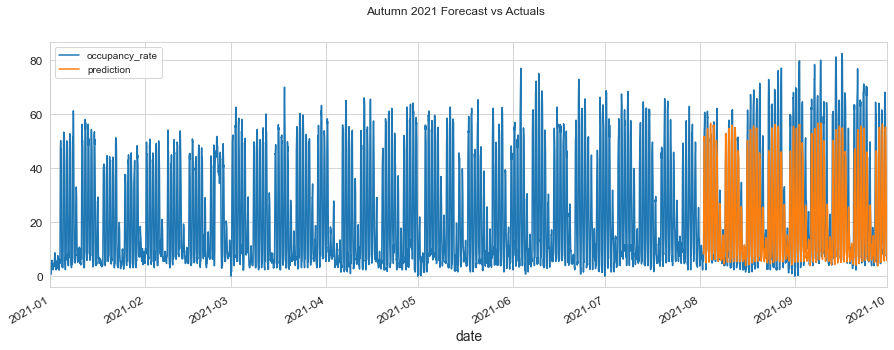

In [72]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['occupancy_rate','prediction']].plot(ax=ax, style=['-','-'])

ax.set_xbound(lower='2021-01-01', upper='2021-10-01')
plot = plt.suptitle('Autumn 2021 Forecast vs Actuals')

## Error metrics on test set

1) Calculate standard metrics

In [70]:
df_test[:600]

,occupancy_rate,date_only,hour,day_of_week,quarter,month,day_of_year,day_of_month,week_of_year,holiday,prediction
date,,,,,,,,,,,
2021-08-02 22:00:00,2.34,2021-08-02,22,0,3,8,214,2,31,0,4.891067
2021-08-02 23:00:00,5.28,2021-08-02,23,0,3,8,214,2,31,0,5.440174
2021-08-02 00:00:00,5.47,2021-08-02,0,0,3,8,214,2,31,0,8.249065
2021-08-02 01:00:00,5.47,2021-08-02,1,0,3,8,214,2,31,0,8.249065
2021-08-02 02:00:00,5.76,2021-08-02,2,0,3,8,214,2,31,0,8.249065
...,...,...,...,...,...,...,...,...,...,...,...
2021-08-26 17:00:00,35.10,2021-08-26,17,3,3,8,238,26,34,0,17.185581
2021-08-26 18:00:00,28.07,2021-08-26,18,3,3,8,238,26,34,0,14.445647
2021-08-26 19:00:00,20.69,2021-08-26,19,3,3,8,238,26,34,0,10.821222


In [71]:
# compute average MAE and MSE
# date_filter = 600

print(round(mean_absolute_error(y_true=df_test['occupancy_rate'][:date_filter], y_pred=df_test['prediction'][:date_filter]), 3))
print(round(mean_squared_error(y_true=df_test['occupancy_rate'][:date_filter], y_pred=df_test['prediction'][:date_filter]), 3))

5.216
57.689


In [328]:
df_test_temp = df_test[['occupancy_rate', 'prediction']]
df_test_temp.head(10)

,occupancy_rate,prediction
162,8.762887,8.377028
163,12.738854,8.163261
164,68.298969,46.381065
165,12.578616,29.395002
166,9.106529,8.163261
167,89.171975,68.826073
168,82.857143,57.757530
169,88.144330,56.412708
170,51.804124,45.894936
171,33.750000,42.322132


2) Look at Worst and Best Predicted Days

In [257]:
# aggregate data
df_test['error'] = df_test['occupancy_rate'] - df_test['prediction']
df_test['abs_error'] = df_test['error'].apply(np.abs)
error_by_day = df_test.groupby(['month','day_of_month']) \
    .mean()[['occupancy_rate','prediction','error','abs_error']]

In [258]:
error_by_day.sort_values('error', ascending=True).head(10)

occupancy_rate  prediction      error  abs_error
month day_of_month                                                  
1     31                 10.824742   40.920586 -30.095843  30.095843
2     28                 12.893082   39.292233 -26.399151  26.399151
12    25                 12.469805   36.990704 -24.520897  25.018140
1     1                  22.130184   44.553688 -22.423504  23.060441
      30                 27.074784   46.263062 -19.188277  23.451129
      14                 27.297573   45.217739 -17.920166  25.962697
      23                 31.366953   48.857655 -17.490702  19.605565
      12                 30.254061   45.668736 -15.414675  25.703168
      15                 31.215674   46.350586 -15.134914  19.799657
2     27                 34.902785   48.640472 -13.737688  17.626291

# Archive

3) Run models

1. Evaluate performance with hour variable only

In [39]:
# run cross-validation

# Init RF and CV
cv = TimeSeriesSplit(n_splits=5)
rf = RandomForestRegressor(n_estimators=250, random_state=42) # will be optimised by grid search

scores = cross_validate(rf, X, y, cv=cv, scoring='neg_mean_squared_error', return_estimator=True)

# Base RMSLE
base_rmsle = np.sqrt(-np.mean(scores["test_score"]))
print("Base Root Meat Squared Error is: {:.5f}".format(base_rmsle))

/Users/christopherkindl/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/christopherkindl/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/christopherkindl/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/christopherkindl/opt/anaconda3/lib/python3.8/site-pack

Base Root Meat Squared Error is: 15.73510


2. Evaluate performance without weather information

In [31]:
# run cross-validation

# Init RF and CV
cv = TimeSeriesSplit(n_splits=5)
rf = RandomForestRegressor(n_estimators=100, random_state=42) # will be optimised by grid search
lr = LinearRegression()

scores = cross_validate(rf, X, y, cv=cv, scoring='neg_mean_squared_error', return_estimator=True)

# Base RMSLE
base_rmsle = np.sqrt(-np.mean(scores["test_score"]))
print("Base Root Meat Squared Error is: {:.5f}".format(base_rmsle))

/Users/christopherkindl/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/christopherkindl/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/christopherkindl/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/christopherkindl/opt/anaconda3/lib/python3.8/site-pack

Base Root Meat Squared Error is: 7.79661


3. Evaluate performance with AdaBoost

In [18]:
cv = TimeSeriesSplit(n_splits=5)
# rf = RandomForestRegressor(n_estimators=100, random_state=42) # will be optimised by grid search
abr = AdaBoostRegressor(random_state=42, n_estimators=2500)

scores = cross_validate(abr, X, y, cv=cv, scoring='neg_mean_squared_error', return_estimator=True)

# Base RMSLE
base_rmsle = np.sqrt(-np.mean(scores["test_score"]))
print("Base Root Meat Squared Error is: {:.5f}".format(base_rmsle))

/Users/christopherkindl/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/christopherkindl/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/christopherkindl/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/christopherkindl/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Base Root Meat Squared Error is: 14.63672


4. Evaluate performance with XGBoost

In [23]:
xgb = XGBRegressor(n_estimators=1000)

scores = cross_validate(xgb, X, y, cv=cv, scoring='neg_mean_squared_error', return_estimator=True)

# Base RMSLE
base_rmsle = np.sqrt(-np.mean(scores["test_score"]))
print("Base Root Meat Squared Error is: {:.5f}".format(base_rmsle))

Base Root Meat Squared Error is: 6.88160


4) Feature importance

In [ ]:
#get feature importance
for idx,estimator in enumerate(scores['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index = attributes,
                                       columns=['importance']).sort_values('importance', ascending=False)
    print('-----------------------------------------------')
    print(feature_importances)